Task 2 <br>
<ol>
<li>Build a fully connected ANN and train it (on GPU)<br>
<li>Build a CNN with MLP on top of it as classifier and train it (on GPU)<br>
<li>Compare the results and plot the learning and evaluation curves<br>
</ol>


First import nescesary tools


 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
%matplotlib inline 
path_data = './data/'

It is prefered to use GPU's 

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

 
Next we need to find dataset
my choice is fashion dataset, it provides a lot of black and white images of clothing.<br>
train data contains data is used to train the model <br>
test contains dataset used to test our net 




In [3]:
train_data = torchvision.datasets.FashionMNIST(root=path_data, train=True, download=True) 
test = torchvision.datasets.FashionMNIST(root=path_data, train=False, download=True) 

Here we normalize the training data

In [4]:
type(train_data)
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

train_data.transform = cifar_transform
test.transform = cifar_transform
train_data.transforms = torchvision.datasets.vision.StandardTransform(cifar_transform)
test.transforms = torchvision.datasets.vision.StandardTransform(cifar_transform)


It is necessary to train shuffle data before training, so not to encourage repetition in data samples
batch size defined "how many images will be used at once",
in in other words " how many images need to be fed to net before we calculate loss function"


In [5]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(train_data, batch_size=4,
                                          shuffle=False, num_workers=2)

In [15]:
train_data_iter = iter(train_dataloader)
images, labels = train_data_iter.next()
#print(images[0])

It's common to couple few images together, for learning purposes  <br>
below I display sample of the data both with corresponding labels 


Sneaker Trouser Ankle boot Pullover


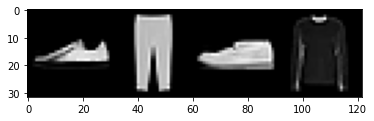

In [7]:
def plot_images(images, labels): 
    
    img_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
    np_img = img_grid.numpy().transpose(1,2,0)  
    plt.imshow(np_img)
    
d_class2idx = train_data.class_to_idx
d_idx2class = dict(zip(d_class2idx.values(),d_class2idx.keys()))

images, labels = train_data_iter.next()
plot_images(images,labels)
print(' '.join('%5s' % d_idx2class[int(labels[j])] for j in range(len(images))))

In [8]:
import torch.nn as nn 
import torch.nn.functional as F 

Define our custom CNN

In [9]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.convlayer1 = nn.Conv2d(1, 6, 4)
        
        self.pool = nn.MaxPool2d(2,2)
    
        self.convlayer2 = nn.Conv2d(6,12,4) 
        self.layer1 = nn.Linear(12*4*4, 160) 
        self.layer2 = nn.Linear(160, 80)
        self.layer3 = nn.Linear(80, 10)                                      
      
      
    def forward(self, x): 
        x = self.pool(F.relu(self.convlayer1(x)))
        x = self.pool(F.relu(self.convlayer2(x)))
        x = x.view(-1, 12*4*4)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)



Make shure the calculation runs on gpu

In [10]:
net = Net().to(device)
print(f"Model sent to {device}")

Model sent to cuda


Optimalisation function

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Main loop<br>
here the data is fed to the neural net


In [12]:
temp_loss = 0 
freq = 1000
datatable = []

print("pass no.\tdata no.\tcurrent loss")
for epoch in range(2):
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)  
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        temp_loss += loss.item()
        if i % freq == freq-1:  
            print(epoch , "\t\t", i+1,"\t\t", temp_loss / freq)
            datatable.append(temp_loss/freq)
            temp_loss = 0 

pass no.	data no.	current loss
0 		 1000 		 1.6097603406980634
0 		 2000 		 0.8052297716364264
0 		 3000 		 0.7089587305546738
0 		 4000 		 0.6671424228874967
0 		 5000 		 0.6005763866878114
0 		 6000 		 0.571845357131213
0 		 7000 		 0.5511144626969472
0 		 8000 		 0.5162136791006197
0 		 9000 		 0.5190252238932881
0 		 10000 		 0.4977753610180225
0 		 11000 		 0.48592011658452977
0 		 12000 		 0.4812187861299608
0 		 13000 		 0.46442368206649554
0 		 14000 		 0.470834335782798
0 		 15000 		 0.46256534973171076
1 		 1000 		 0.44673757406152437
1 		 2000 		 0.4372407563420129
1 		 3000 		 0.43518076543463396
1 		 4000 		 0.40173786971063236
1 		 5000 		 0.40545866412558823
1 		 6000 		 0.4060557878459804
1 		 7000 		 0.41831591113039757
1 		 8000 		 0.4129446988023119
1 		 9000 		 0.383735816362896
1 		 10000 		 0.3993373701684177
1 		 11000 		 0.39822269253706327
1 		 12000 		 0.39304605417585115
1 		 13000 		 0.38776337667834015
1 		 14000 		 0.3662551600370789
1 		 15000 		 0.398929

Plot the loss 

Text(0, 0.5, 'loss')

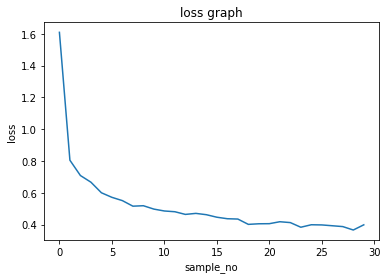

In [18]:
plt.plot(datatable)
plt.title("loss graph")
plt.xlabel("sample_no")
plt.ylabel("loss")


Calculate final accuracy  <br>


In [14]:
total = 0
correct = 0  
with torch.no_grad():
    for i, data in enumerate(testloader): 
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size()[0]
        correct += (predicted == labels).sum().item()
    
print("End accuracy: ", correct/total)



End accuracy:  0.87255
